# Major Depressive Disorder Diagnosis

In [1]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [4]:
class Args:
    # arugments
    epochs=50
    bs=16
    lr=0.001
    momentum=0.9
    num_classes=3
    verbose='store_true'
    seed=674

args = Args()    

np.random.seed(args.seed)
random.seed(args.seed)
torch.manual_seed(args.seed)

In [5]:
#Setting torch environment

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device: ', DEVICE)

Using PyTorch version: 1.7.1  Device:  cuda


- - -

# Data Handling

## Dataset check

In [6]:
# HRV 데이터셋 불러오기
hrv_df = pd.read_csv('E:/RESEARCH/Datasets/HRV/HRV_samsung/HRV_REV_all.csv', sep=',')
hrv_df.head()

,sub,VISIT,disorder,age,gender,HAMD,HAMA,PDSS,ASI,APPQ,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
0,E001,4,2,23,1,2,2,1,12,22,...,41.544667,190.107000,298.508333,206.862333,1.284000,695.477333,65.707000,14.054333,3.911333,34.998000
1,E001,5,2,23,1,12,7,0,12,24,...,39.825333,143.756667,115.695333,202.602667,0.585000,462.054667,69.040000,14.117333,6.255000,35.544333
2,E002,1,2,38,1,14,17,14,31,122,...,20.052000,22.006000,50.182000,32.529333,2.499333,104.717000,92.789333,11.013333,0.945667,35.086000
3,E002,2,2,38,1,13,36,16,32,139,...,20.201667,55.579000,84.441000,18.754000,5.803000,158.774333,85.980667,12.608333,0.785667,36.141000
4,E002,3,2,38,1,7,10,11,23,70,...,74.788000,182.229000,530.565667,546.574000,1.685667,1259.368667,84.368667,14.285667,0.648000,35.879000


* disorder(=label): 1(Depression), 2(Panic Disorder), 3(Control)

In [7]:
hrv_df.shape

(479, 93)

HRV measuring steps
* b1 - s - b2 - r - b3 - c
* Each has following variables (Total 13 variables)
> SDNN, NN50, PNN50, RMSSD, VLF, LF, HF, LF/HF, POWER, HR, RESP, SC, TEMP

## Dataset Separation

* disorder= 1:(Depression), 2:(Panic Disorder), 3:(Control)

In [8]:
hrv_df.columns

Index(['sub', 'VISIT', 'disorder', 'age', 'gender', 'HAMD', 'HAMA', 'PDSS',
       'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI', 'b1SDNN', 'b1NN50',
       'b1PNN50', 'b1RMSSD', 'b1VLF', 'b1LF', 'b1HF', 'b1LF/HF', 'b1POWER',
       'b1HR', 'b1RESP', 'b1SC', 'b1TEMP', 'sSDNN', 'sNN50', 'sPNN50',
       'sRMSSD', 'sVLF', 'sLF', 'sHF', 'sLF/HF', 'sPOWER', 'sHR', 'sRESP',
       'sSC', 'sTEMP', 'b2SDNN', 'b2NN50', 'b2PNN50', 'b2RMSSD', 'b2VLF',
       'b2LF', 'b2HF', 'b2LF/HF', 'b2POWER', 'b2HR', 'b2RESP', 'b2SC',
       'b2TEMP', 'rSDNN', 'rNN50', 'rPNN50', 'rRMSSD', 'rVLF', 'rLF', 'rHF',
       'rLF/HF', 'rPOWER', 'rHR', 'rRESP', 'rSC', 'rTEMP', 'b3SDNN', 'b3NN50',
       'b3PNN50', 'b3RMSSD', 'b3VLF', 'b3LF', 'b3HF', 'b3LF/HF', 'b3POWER',
       'b3HR', 'b3RESP', 'b3SC', 'b3TEMP', 'cSDNN', 'cNN50', 'cPNN50',
       'cRMSSD', 'cVLF', 'cLF', 'cHF', 'cLF/HF', 'cPOWER', 'cHR', 'cRESP',
       'cSC', 'cTEMP'],
      dtype='object')

In [9]:
hrv_df["disorder"].value_counts() ## MDD 136, PD 149, Control 194

3    194
2    149
1    136
Name: disorder, dtype: int64

In [10]:
hrv_ALL = hrv_df
hrv_MDDPD = hrv_df[hrv_df["disorder"].isin([1,2])]  ## for MDD vs PD task
hrv_MDDC = hrv_df[hrv_df["disorder"].isin([1,3])]   ## for MDD vs Control task
hrv_PDC = hrv_df[hrv_df["disorder"].isin([2,3])]    ## for PD  vs Control task

In [14]:
hrv_MDDC.shape

(330, 93)

- - -

## Data preprocessing

In [13]:
## scaler setting for data standardization.
scaler = MinMaxScaler()

In [18]:
## Selecting hrv dataset for the task
# hrv = hrv_ALL
# hrv = hrv_MDDPD
hrv = hrv_MDDC
# hrv = hrv_PDC

In [19]:
hrv

,sub,VISIT,disorder,age,gender,HAMD,HAMA,PDSS,ASI,APPQ,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
7,E003,1,1,57,2,17,7,0,7,24,...,11.042667,132.564333,85.853000,15.020333,5.159667,233.437667,76.412667,12.575667,0.655000,35.631333
8,E003,2,1,57,2,7,7,0,16,23,...,17.207000,38.888000,33.040000,12.504333,3.691333,84.432667,56.474000,12.367667,0.347000,33.237000
9,E003,3,1,57,2,5,3,0,6,11,...,58.545667,30.004333,26.829333,59.476000,0.653000,116.309667,53.746667,13.226667,0.575000,32.853000
10,E003,4,1,57,2,1,1,0,20,31,...,17.261000,37.713333,34.427333,16.011333,2.146000,88.152000,62.778667,12.404000,0.773000,35.046000
11,E003,5,1,57,2,12,13,0,3,12,...,34.473333,40.431333,18.012333,52.686667,0.343333,111.129667,63.868000,10.994667,2.080333,34.751667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,E103,1,1,71,1,20,14,0,47,114,...,13.506000,10.706000,13.746700,12.347300,14.575300,36.799700,86.526300,10.268700,4.586330,34.528700
456,E103,2,1,71,1,14,3,0,41,84,...,11.523700,34.633700,16.170700,3.551670,5.129330,54.356000,74.020700,11.658700,3.782000,33.023700
457,E103,3,1,71,1,16,15,0,33,56,...,22.506700,18.495700,22.447300,38.283000,1.808670,79.226300,73.282300,12.570000,4.173670,32.164700
458,E103,4,1,71,1,0,0,0,28,65,...,69.218700,41.291700,39.600700,225.653000,0.177000,306.545000,65.475700,13.548300,1.566000,31.549000


In [20]:
## Separating HRV dataset by experimental steps.
hrv_only = hrv.drop(columns=['sub', 'VISIT', 'disorder', 'age','gender','HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ','PSWQ','SPI','PSS','BIS','SSI']) ##leave the variables only about HRV features.
hrv_only[:] = scaler.fit_transform(hrv_only[:])  ##Standardizing. if not necessary, delete.  
hrv_b1 = hrv.filter(regex='^b1')
hrv_s = hrv.filter(regex='^s')
hrv_b2 = hrv.filter(regex='^b2')
hrv_r = hrv.filter(regex='^r')
hrv_b3 = hrv.filter(regex='^b3')
hrv_c = hrv.filter(regex='^c')

In [21]:
hrv_only.head()

,b1SDNN,b1NN50,b1PNN50,b1RMSSD,b1VLF,b1LF,b1HF,b1LF/HF,b1POWER,b1HR,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
7,0.029739,0.000000,0.000000,0.013392,0.001768,0.000557,0.001484,0.021171,0.001327,0.424606,...,0.007717,0.001743,0.000415,0.000355,0.145641,0.000741,0.429173,0.370844,0.042560,0.934622
8,0.080975,0.000000,0.000000,0.041879,0.005922,0.001584,0.004429,0.020513,0.004320,0.093100,...,0.015267,0.000490,0.000143,0.000292,0.102908,0.000239,0.132928,0.345104,0.021541,0.724881
9,0.684928,0.105263,0.134041,0.473378,0.044866,0.022810,0.058072,0.021797,0.045589,0.155741,...,0.065897,0.000371,0.000111,0.001478,0.014484,0.000347,0.092406,0.451407,0.037100,0.691243
10,0.076520,0.052632,0.060752,0.055723,0.004645,0.001566,0.006871,0.010026,0.004524,0.188282,...,0.015333,0.000474,0.000151,0.000380,0.057934,0.000252,0.226602,0.349600,0.050612,0.883347
11,0.148438,0.039474,0.047252,0.146307,0.005542,0.005562,0.041980,0.006874,0.017082,0.161077,...,0.036414,0.000510,0.000066,0.001307,0.005471,0.000329,0.242787,0.175192,0.139826,0.857564


In [22]:
hrv_only.shape

(330, 78)

In [23]:
## Check whethere each phase contains the same variables.
print("HRV baseline #1 shape is:", hrv_b1.shape[1])
print("HRV stress shape is:", hrv_s.shape[1])
print("HRV baseline #2 shape is:", hrv_b2.shape[1])
print("HRV rest shape is:", hrv_r.shape[1])
print("HRV baseline #3 shape is:", hrv_b3.shape[1])
print("HRV c shape is:", hrv_b1.shape[1])

HRV baseline #1 shape is: 13
HRV stress shape is: 14
HRV baseline #2 shape is: 13
HRV rest shape is: 13
HRV baseline #3 shape is: 13
HRV c shape is: 13


In [24]:
hrv_s = hrv_s.drop(columns=['sub'])

In [99]:
## Renaming the columns for further calculation.
## We need to generate new dataframes to compare the phases.
hrv_sub = hrv.loc[:, ['sub']]
hrv_disorder = hrv.loc[:,['disorder']] -1 ## 0(Depression), 1(Panic Disorder), 2(Control)
hrv_gender = hrv.loc[:,['gender']]
hrv_HAMD = hrv.loc[:,['HAMD']]
hrv_PDSS = hrv.loc[:,['PDSS']]

hrv_variables = ["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"]
hrv_b1_rename = hrv_b1.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_b2_rename = hrv_b2.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_b3_rename = hrv_b3.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_s_rename = hrv_s.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_r_rename = hrv_r.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)
hrv_c_rename = hrv_c.set_axis(["SDNN", "NN50", "PNN50", "RMSSD", "VLF", "LF", "HF", "LF/HF", "POWER", "HR", "RESP", "SC", "TEMP"], axis=1)

In [26]:
hrv_disorder.value_counts()

disorder
2           194
0           136
dtype: int64

- - -

## Comparisons between Phases

* HRV measuring steps: b1 - s - b2 - r - b3 - c
* Each has following variables (Total 13 variables): SDNN, NN50, PNN50, RMSSD, VLF, LF, HF, LF/HF, POWER, HR, RESP, SC, TEMP

Since the experimental phase steps are "b1-s-b2-r-b3-c", there are total 5 between phases

### 1) Baseline 1 - Stress phase

In [27]:
hrv_b1_s_sub = hrv_b1_rename - hrv_s_rename
hrv_b1_s_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
7,-7.393333,0.000000,0.000000,-3.564667,2.731333,-32.349333,-12.728667,-1.022000,-42.347000,-6.320333,3.604333,-0.458333,-0.341000
8,0.515667,-1.666667,-0.028333,-6.201667,55.459000,-43.157000,-17.901000,-1.011667,-5.598667,-2.875000,-2.257667,-0.598333,-0.356000
9,74.491667,-2.000000,-0.033333,75.039667,48.674000,-334.605333,-874.947000,0.138000,-1160.878667,2.646667,-2.360333,-0.524000,0.002333
10,-6.059000,-2.666667,-0.039000,-8.579333,30.772000,-70.413000,-11.943000,-0.968000,-51.584667,-3.645333,-1.146333,-0.455667,-0.111000
11,-5.136667,-6.000000,-0.088333,4.703667,-36.013333,-217.416667,217.847000,-2.355333,-35.583333,-5.977000,0.106333,-0.869667,0.350333


### 2) Stress - Baseline 2 phase

In [28]:
hrv_s_b2_sub = hrv_s_rename - hrv_b2_rename
hrv_s_b2_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
7,6.122667,0.000000,0.000000,3.410333,-3.117000,21.98300,13.936333,0.095333,32.802333,6.173667,-0.887000,0.186000,-0.106667
8,3.979667,1.333333,0.022333,7.626333,-15.517333,25.58100,32.232667,-0.229667,42.296333,2.492667,1.902333,0.487000,-0.727000
9,-258.083333,-2.666667,-0.046333,-394.522667,-14999.453670,-24896.51867,-4831.064000,-2.002333,-44727.035670,-6.971000,1.244667,0.400000,0.178000
10,8.444667,4.000000,0.060000,16.226667,-33.200333,71.10100,51.684000,-0.322000,89.585000,3.215000,2.236000,0.229667,0.222667
11,23.653333,6.666667,0.099333,26.199333,77.795000,256.78800,76.952333,0.631333,411.535333,4.801667,2.372333,0.432667,-0.193667


### 3) Baseline2 - Rest phase

In [29]:
hrv_b2_r_sub = hrv_b2_rename - hrv_r_rename
hrv_b2_r_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
7,-21.490333,0.000000,0.000000,-8.399667,-281.650333,-129.093333,-37.269000,-1.768000,-448.012333,-0.113333,-0.301533,0.064667,-0.437000
8,-2.142333,0.333333,0.006000,-0.066333,-19.280333,25.987667,-3.229000,1.378333,3.478333,0.265000,-0.769400,0.091000,-0.101667
9,246.299333,5.000000,0.084333,373.393667,15329.818003,25166.595003,2971.524334,2.179000,43467.936670,8.244333,-0.343400,0.223333,-0.013667
10,-1.649333,-0.666667,-0.010333,-5.992000,-4.815333,-8.711667,-12.078000,0.375667,-25.605000,-0.277000,-3.969667,0.096667,0.017667
11,-3.302333,-0.666667,-0.011333,-7.278000,5.790000,21.553333,-6.970333,1.707000,20.373333,2.330333,-0.845000,0.260333,-0.011667


### 4) Rest - Baseline 3 phase

In [30]:
hrv_r_b3_sub = hrv_r_rename - hrv_b3_rename
hrv_r_b3_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
7,15.283333,0.000000,0.000000,7.927667,229.294667,108.769000,36.793000,-0.268667,374.856000,0.032333,0.617533,0.027667,-0.020667
8,-5.297333,0.000000,0.000000,-2.739000,-12.043000,-35.270000,-11.795000,-0.684667,-59.107333,-1.786333,-1.007600,0.018000,1.268667
9,-78.737333,-2.000000,-0.035667,-91.039333,-933.084333,-3555.846000,-2.801667,-0.442000,-4491.731667,-1.204667,-1.336933,0.005667,0.526333
10,-8.230000,0.000000,-0.000333,-2.272000,-115.838000,-10.116667,-16.952000,0.152000,-142.906000,2.137333,1.328000,-0.058667,-0.123667
11,-9.034000,-2.333333,-0.038333,-9.288333,-30.323000,-41.615333,-19.606333,-0.787333,-91.544667,-0.878333,-0.207000,-0.298000,0.174667


### 5) Baseline 3 - Recovery phase

In [31]:
hrv_b3_c_sub = hrv_b3_rename - hrv_c_rename
hrv_b3_c_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
7,-3.581333,0.000000,0.000000,-2.860000,-58.629667,-46.155667,-3.755333,-1.461333,-108.540333,1.794333,0.239667,-0.258000,0.444667
8,3.489000,-0.333333,-0.006000,-0.143000,17.172000,15.998667,23.115667,-2.428667,56.285333,1.231333,0.252333,-0.055667,0.063667
9,101.116333,1.333333,0.021333,117.364000,996.370667,3888.013334,3130.417000,0.228333,8014.801000,3.530333,-0.780333,-0.282667,-0.188000
10,0.299333,-0.333333,-0.005333,2.988333,136.682667,5.673667,27.218000,-0.987000,169.573667,-2.039333,0.146000,-0.263000,0.193667
11,-1.378333,-2.666667,-0.038000,-3.335667,3.015333,35.892667,6.395333,0.762000,45.304000,-3.795333,0.831667,-0.620333,0.182667


### 6) Stress - Rest phase

* This is what SMC checks for the research

In [32]:
hrv_s_r_sub = hrv_s_rename - hrv_r_rename
hrv_s_r_sub.head()

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP
7,-15.367667,0.000000,0.000000,-4.989333,-284.767333,-107.110333,-23.332667,-1.672667,-415.210000,6.060333,-1.188533,0.250667,-0.543667
8,1.837333,1.666667,0.028333,7.560000,-34.797667,51.568667,29.003667,1.148667,45.774667,2.757667,1.132933,0.578000,-0.828667
9,-11.784000,2.333333,0.038000,-21.129000,330.364333,270.076333,-1859.539666,0.176667,-1259.099000,1.273333,0.901267,0.623333,0.164333
10,6.795333,3.333333,0.049667,10.234667,-38.015667,62.389333,39.606000,0.053667,63.980000,2.938000,-1.733667,0.326333,0.240333
11,20.351000,6.000000,0.088000,18.921333,83.585000,278.341333,69.982000,2.338333,431.908667,7.132000,1.527333,0.693000,-0.205333


- - -

# Data Visualization

In [38]:
hrv.describe()

,VISIT,disorder,age,gender,HAMD,HAMA,PDSS,ASI,APPQ,PSWQ,...,cRMSSD,cVLF,cLF,cHF,cLF/HF,cPOWER,cHR,cRESP,cSC,cTEMP
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,2.978788,2.175758,41.657576,1.660606,6.472727,6.039394,0.875758,13.163636,35.754545,34.387879,...,43.669894,655.276951,1241.578498,513.758725,4.321076,2410.614499,74.315256,12.973306,1.272926,34.347977
std,1.412979,0.985928,16.279689,0.474223,8.240359,7.623450,2.685040,15.833016,37.156742,13.510139,...,76.679374,5482.108350,11591.265918,3063.010314,4.374765,19127.366046,10.333847,1.413546,1.880320,1.503981
min,1.000000,1.000000,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.742333,2.278330,5.177670,0.952000,0.155333,13.472300,47.527300,9.579000,0.031333,24.962000
25%,2.000000,1.000000,27.000000,1.000000,0.000000,0.250000,0.000000,1.000000,8.250000,26.000000,...,16.977167,34.590425,40.576525,17.362917,1.377832,116.734250,67.796667,12.049950,0.349667,33.856500
50%,3.000000,3.000000,40.000000,2.000000,2.000000,2.500000,0.000000,7.000000,24.000000,32.000000,...,24.722650,73.981350,100.258333,39.443000,3.052168,231.956333,73.649833,12.888833,0.650333,34.706833
75%,4.000000,3.000000,56.000000,2.000000,12.000000,10.000000,0.000000,19.000000,47.750000,41.000000,...,41.175500,165.100917,236.850000,114.432500,5.629082,523.333917,81.191600,13.713175,1.377250,35.301167
max,5.000000,3.000000,77.000000,2.000000,32.000000,37.000000,17.000000,68.000000,162.000000,71.000000,...,821.213333,74759.886000,194319.933300,39587.384670,34.516000,296679.451000,114.832000,17.659667,14.685300,36.377667


## Age and Disorder

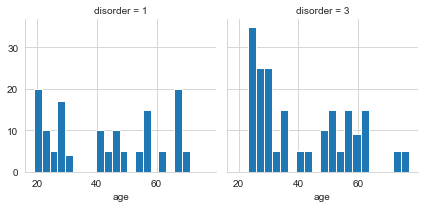

In [37]:
sns.set_style('whitegrid')
g = sns.FacetGrid(hrv, col='disorder')
g.map(plt.hist, 'age', bins=20)

## Gender and Disorder

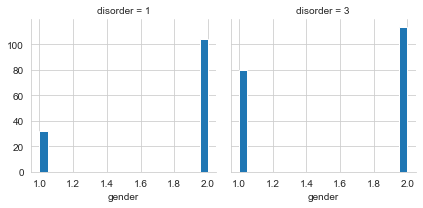

In [39]:
sns.set_style('whitegrid')
g = sns.FacetGrid(hrv, col='disorder')
g.map(plt.hist, 'gender', bins=20)

- - -

# Data Analysis

## Data Selection

In [134]:
## Generating dataset with y label on it. 
hrv_data = pd.concat([hrv_s_r_sub, hrv_disorder], axis=1)

In [135]:
hrv_data

,SDNN,NN50,PNN50,RMSSD,VLF,LF,HF,LF/HF,POWER,HR,RESP,SC,TEMP,disorder
7,-15.367667,0.000000,0.000000,-4.989333,-284.767333,-107.110333,-23.332667,-1.672667,-415.210000,6.060333,-1.188533,0.250667,-0.543667,0
8,1.837333,1.666667,0.028333,7.560000,-34.797667,51.568667,29.003667,1.148667,45.774667,2.757667,1.132933,0.578000,-0.828667,0
9,-11.784000,2.333333,0.038000,-21.129000,330.364333,270.076333,-1859.539666,0.176667,-1259.099000,1.273333,0.901267,0.623333,0.164333,0
10,6.795333,3.333333,0.049667,10.234667,-38.015667,62.389333,39.606000,0.053667,63.980000,2.938000,-1.733667,0.326333,0.240333,0
11,20.351000,6.000000,0.088000,18.921333,83.585000,278.341333,69.982000,2.338333,431.908667,7.132000,1.527333,0.693000,-0.205333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455,-8.292970,-1.333330,-0.015333,-16.972330,-1.679000,9.547300,-3.531670,1.538000,4.336300,3.323400,-2.190300,-0.112670,0.597000,0
456,-5.058300,0.000000,0.000000,-5.294370,-62.180700,-75.469600,-9.382630,-3.316000,-147.033000,7.859300,0.742000,-0.357000,-0.168000,0
457,2.379000,-0.333333,-0.004667,-4.420370,-60.123700,-26.759000,-3.662600,-0.289340,-90.546000,6.704000,0.422300,-0.093670,0.606400,0
458,4.187300,6.333370,0.084666,8.228300,-569.375000,-3152.014000,-2908.017000,0.717003,-6629.406000,4.631300,-2.345400,0.528670,0.278700,0


In [173]:
X = hrv_b1_s_sub
Y = hrv_disorder

In [174]:
var_selection = ["SDNN", "NN50","PNN50", "RMSSD", "LF", "HF", "LF/HF", "HR"] ## Choose the variables that must be adopted for input values
X = X.loc[:,var_selection]

## Train-Test Split

In [175]:
X.columns

Index(['SDNN', 'NN50', 'PNN50', 'RMSSD', 'LF', 'HF', 'LF/HF', 'HR'], dtype='object')

In [176]:
## Split X and Y into training dataset and test dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [177]:
print("x_train dataset shape is", x_train.shape)
print("y_train dataset shape is", y_train.shape)

print("x_test dataset shape is", x_test.shape)
print("y_test dataset shape is", y_test.shape)

x_train dataset shape is (264, 8)
y_train dataset shape is (264, 1)
x_test dataset shape is (66, 8)
y_test dataset shape is (66, 1)


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.bs, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.bs, shuffle=False, num_workers=4)

- - -

## Regression

In [178]:
logistic_reg = LogisticRegression(solver='lbfgs', max_iter = 4000)
logistic_reg.fit(x_train, y_train.values.ravel())

LogisticRegression(max_iter=4000)

In [179]:
predictions = logistic_reg.predict(x_test)

In [180]:
print(confusion_matrix(y_test,predictions))

[[ 7 19]
 [12 28]]


- - -

## Decision Tree

In [181]:
dt_model=DecisionTreeClassifier()
dt_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [182]:
dt_pred = dt_model.predict(x_test)

In [183]:
print(confusion_matrix(y_test,dt_pred))

[[13 13]
 [11 29]]


In [184]:
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       0.54      0.50      0.52        26
           2       0.69      0.72      0.71        40

    accuracy                           0.64        66
   macro avg       0.62      0.61      0.61        66
weighted avg       0.63      0.64      0.63        66



- - -

## Random Forest Classification

In [185]:
rf= RandomForestClassifier(n_estimators=5000)
rf.fit(x_train, y_train.values.ravel())

RandomForestClassifier(n_estimators=5000)

In [186]:
rf_pre=rf.predict(x_test)

In [187]:
print(confusion_matrix(y_test, rf_pre))

[[11 15]
 [14 26]]


In [188]:
print(classification_report(y_test, rf_pre))

              precision    recall  f1-score   support

           0       0.44      0.42      0.43        26
           2       0.63      0.65      0.64        40

    accuracy                           0.56        66
   macro avg       0.54      0.54      0.54        66
weighted avg       0.56      0.56      0.56        66



- - -

## XGBoosts Classifier

In [189]:
xgboost = XGBClassifier(n_estimators=1000, eval_metric='mlogloss')
xgboost.fit(x_train, y_train)

C:\Users\user\anaconda3\envs\mlprac\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\user\anaconda3\envs\mlprac\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [190]:
xg_pred = xgboost.predict(x_test)

In [191]:
print(confusion_matrix(y_test, xg_pred))

[[12 14]
 [15 25]]


In [192]:
print(classification_report(y_test, xg_pred))

              precision    recall  f1-score   support

           0       0.44      0.46      0.45        26
           2       0.64      0.62      0.63        40

    accuracy                           0.56        66
   macro avg       0.54      0.54      0.54        66
weighted avg       0.56      0.56      0.56        66



- - -

## Multi-Layer Perceptron

* Simple MLP

In [73]:
input_size = x_train.shape[1]

In [74]:
class MLP_HRV(nn.Module):
    def __init__(self):
        super(MLP_HRV, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 3)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.layer1(x)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [75]:
model = MLP_HRV().to(DEVICE)
print(model)

MLP_HRV(
  (layer1): Linear(in_features=12, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=3, bias=True)
)


In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [77]:
x_train = torch.tensor(x_train.values)

In [78]:
for epoch in range(args.epochs):
    loss = 0
    batch = len(train_loader)

    for images, labels in train_loader: 
        images = images.view(-1, input_size).to(DEVICE) 
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        hypothesis = model(images)
        cost = criterion(hypothesis, labels)
        cost.backward()
        optimizer.step()
        loss += cost / batch

    print('Epoch:', '%03d' % (epoch + 1), 'Training loss =', '{:.5f}'.format(loss))

NameError: name 'train_loader' is not defined

- - -

## Convolutional Neural Network

In [ ]:
print("X shape is ", X.shape)
print("Y shape is ", Y.shape)

In [ ]:
X.head()